In [ ]:
# experiment with things that would be useful and make sense, not random stuff.

In [4]:
# alternating least squares with weighted regularization
# loading packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from collections import namedtuple
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from typing import Iterable, Any, Dict
import pickle


from matplotlib.pyplot import rcParams
import seaborn as sb

In [5]:
%matplotlib inline
rcParams['figure.figsize'] = 8, 4
sb.set_style('whitegrid')

# Data Preparation

In [6]:
# location for the datasets

address2 = 'CSV/cdnelastic_VoD.csv'
address = 'CSV/videos.csv'

In [7]:
# loading the datasets

allcols = ['timestamp','statuscode','contentlength','host','timefirstbyte','timetoserv','hit','contenttype',
           'cachecontrol','cachename','popname','method','protocol','path','uid','sid','livechannel',
           'contentpackage','assetnumber','maxage','coordinates','devicebrand','devicefamily','devicemodel',
           'osfamily','uafamily','uamajor','manifest','fragment']
somecols = ['@timestamp','statuscode','contentlength','host','timetoserv','hit','contenttype',
              'protocol','uid','sid','livechannel','contentpackage','assetnumber','coordinates',
              'uafamily']
missing_values = ['n/a','na','--','NaN','NA','-']
# cdnset2 = pd.read_csv(address2,
#                      header=0,
#                      nrows=1000000,
#                      parse_dates=[0],
#                      comment='#',
#                      names=somecols,
#                      na_values=missing_values
#                     )
# print(cdnset2.info())
cdnset2 = pd.read_csv(address2,  na_values=missing_values)
cdnset2.head(2)

,coordinates,timetoserv,uafamily,sid,contenttype,statuscode,uid,protocol,hit,@timestamp,contentpackage,host,assetnumber,livechannel,contentlength
0,1.0,0.022135,16.0,3871,video/mp4,200,NaN,HTTP/1.1,miss,2088-05-13T09:20:46.000Z,55.0,15,54.0,NaN,33963.682540
1,1.0,0.000248,16.0,3323,video/mp4,200,NaN,HTTP/1.1,hit,2088-05-13T09:20:55.000Z,55.0,15,54.0,NaN,518.730159


In [7]:
# cdnset = cdnset2[['timestamp', 'uid', 'livechannel']]

In [8]:
cdnset = cdnset2[['@timestamp', 'uid', 'contentpackage']]
# cdnset = pd.read_csv(address,  na_values=missing_values)

In [9]:
cdnset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3696294 entries, 0 to 3696293
Data columns (total 3 columns):
 #   Column          Dtype  
---  ------          -----  
 0   @timestamp      object 
 1   uid             float64
 2   contentpackage  float64
dtypes: float64(2), object(1)
memory usage: 84.6+ MB


In [10]:
cdnset.head(2)

,@timestamp,uid,contentpackage
0,2088-05-13T09:20:46.000Z,NaN,55.0
1,2088-05-13T09:20:55.000Z,NaN,55.0


In [11]:
cdnset['@timestamp'] = pd.to_datetime(cdnset['@timestamp'])

/tmp/ipykernel_145/1231525476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdnset['@timestamp'] = pd.to_datetime(cdnset['@timestamp'])


In [12]:
cdnset.head(2)

,@timestamp,uid,contentpackage
0,2088-05-13 09:20:46+00:00,NaN,55.0
1,2088-05-13 09:20:55+00:00,NaN,55.0


In [13]:
cdnset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3696294 entries, 0 to 3696293
Data columns (total 3 columns):
 #   Column          Dtype              
---  ------          -----              
 0   @timestamp      datetime64[ns, UTC]
 1   uid             float64            
 2   contentpackage  float64            
dtypes: datetime64[ns, UTC](1), float64(2)
memory usage: 84.6 MB


In [14]:
# removing missing values for user id

cdnset3 = cdnset.dropna(subset=['uid'])

In [15]:
cdnset3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269957 entries, 53 to 3696265
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   @timestamp      269957 non-null  datetime64[ns, UTC]
 1   uid             269957 non-null  float64            
 2   contentpackage  269957 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(2)
memory usage: 8.2 MB


In [16]:
df_cdn = cdnset3.groupby(['uid', 'contentpackage'], as_index=False).count()
df_cdn = df_cdn.astype(int)
# df_cdn.head(2)

In [17]:
'''
find a different way to engineer the ratings, not using frequencies.
this is different with liveTV

Engineer ratings in a binary way, e.g., yes/no, if requested then yes, otherwise no (binary rating)
Research if it makes sense.

Looking at the data at the host level for different time windows, very low priority to uid
Host based analytics with time. (host/time vs content)

'''
df_cdn.rename(columns={'@timestamp':'requests'}, inplace=True)
df_cdn.head(2)

,uid,contentpackage,requests
0,24,3528,78
1,59,918,1


In [18]:
df_cdn.shape

(16109, 3)

In [19]:
df_cdn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16109 entries, 0 to 16108
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   uid             16109 non-null  int64
 1   contentpackage  16109 non-null  int64
 2   requests        16109 non-null  int64
dtypes: int64(3)
memory usage: 377.7 KB


In [20]:
print('unique uid: ',len(df_cdn.uid.unique()))
print('unique vod: ',len(df_cdn.contentpackage.unique()))

unique uid:  3670
unique vod:  3422


In [21]:
# the maximum number of requests for particular vod

kubwa = df_cdn.requests.max()
print(kubwa)

5809


In [22]:
#kubwa = df_cdn_freq.timestamp.max()
df_cdn['rating'] = np.where(df_cdn.requests==kubwa,
                5,
                np.where(df_cdn.requests>=0.75*kubwa,
                        4,
                        np.where(df_cdn.requests>=0.5*kubwa,
                                3,
                                np.where(df_cdn.requests>=0.25*kubwa,
                                        2,
                                        np.where(df_cdn.requests>1,
                                                1,
                                                df_cdn.requests)))))

In [23]:
df_cdn.tail(4)

,uid,contentpackage,requests,rating
16105,28725,3219,1,1
16106,28726,2918,31,1
16107,28729,2829,4,1
16108,28732,3939,1,1


In [24]:
df_cdn1 = df_cdn[['uid','contentpackage','rating']]

### Collaborative filtering will start by constructing a user-item matrix

In [25]:
'''
check on this -> frequent itemsets
then do some aggregations;
    prediction of what a particular user may want to watch next (maybe based on other similar users),
    prediction of popularity of a given item.    

'''
# creating the matrix

ratings1 = df_cdn1.pivot(index='uid', columns='contentpackage').fillna(0, downcast='infer')
print(ratings1.shape)


# n_users = df_cdn['uid'].unique().shape[0]
# n_items = df_cdn['contentpackage'].unique().shape[0]
# #print('users:',n_users,'and items:',n_items)
# ratings = np.zeros((n_users, n_items))
# for row in df_cdn.itertuples(index=False):
#     ratings[row.uid - 1, row.contentpackage - 1] = row.rating
    
# print(ratings)



(3670, 3422)


In [26]:
ratings = np.array(ratings1)
print(ratings.shape)
print(ratings)

(3670, 3422)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


In [27]:
# checking for non-zero elements in the matrix
# if dataset too sparse (sparsity below 1%)

matrix_size = np.prod(ratings.shape)
interaction = np.flatnonzero(ratings).shape[0]
sparsity = 100 * (interaction / matrix_size)

print('dimension: ', ratings.shape)
print('sparsity: {:.1f}%'.format(sparsity))
ratings

dimension:  (3670, 3422)
sparsity: 0.1%


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

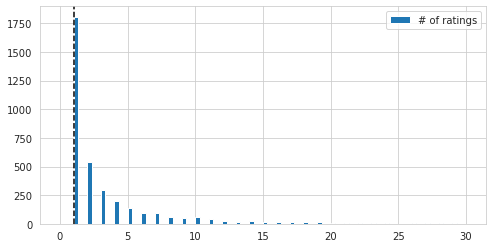

In [29]:
# shows at least one vod is rated by a particular user
# thus for random split we will use this for testing algorithm

'''
improve visualization to see specific number of users who rated how many movies.
'''

plt.hist(np.sum(ratings != 0, axis = 1), range=[0, 30],histtype = 'stepfilled', bins = 90, label = '# of ratings')
plt.axvline(x = 1, color = 'black', linestyle = '--')
plt.legend(loc = "upper right")
plt.show()

In [30]:
# train_test_split for the dataset

def create_train_test(ratings):
    
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_index = np.random.choice(np.flatnonzero(ratings[user]), size=1, replace=False)

        train[user, test_index] = 0.0
        test[user, test_index] = ratings[user, test_index]

    # making sure train and test set are exclusive
    assert np.all(train * test == 0)
    return train, test

In [31]:
# performing the split

train, test = create_train_test(ratings)
del ratings
train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Matrix Factorization

In [32]:
# creating the matrix factorization (MF) class for modeling purpose

class WRMFClass:
    """
    Train a matrix factorization model using Alternating Least Squares
    to predict empty entries in a matrix
    
    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm
        
    n_factors : int
        number of latent factors to use in matrix 
        factorization model, some machine-learning libraries
        denote this as rank
        
    reg : float
        regularization term for item/user latent factors,
        since lambda is a keyword in python we use reg instead
    """

    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors  
        
    def fit(self, train, test):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))
        
        # record the training and testing mse for every iteration
        # to show convergence later (usually, not worth it for production)
        self.test_mse_record  = []
        self.train_mse_record = []   
        for _ in range(self.n_iters):
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors) 
            predictions = self.predict()
            test_mse = self.compute_mse(test, predictions)
            train_mse = self.compute_mse(train, predictions)
            self.test_mse_record.append(test_mse)
            self.train_mse_record.append(train_mse)
        
        return self    
    
    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs
    
    def predict(self):
        """predict ratings for every user and item"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred
    
    @staticmethod
    def compute_mse(y_true, y_pred):
        """ignore zero terms prior to comparing the mse"""
        mask = np.nonzero(y_true)
        mse = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
        return mse
    

In [33]:
# visualizing the training and testing

def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label = 'Test', linewidth = linewidth)
    plt.plot(model.train_mse_record, label = 'Train', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('RMSE')
    plt.legend(loc = 'best')

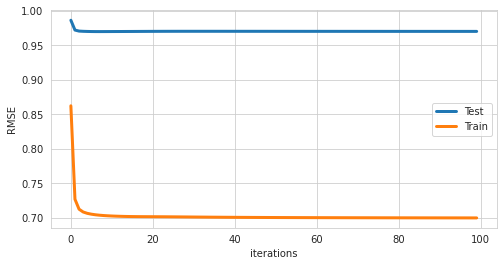

In [34]:
# testing the class to see if it works

als = WRMFClass(n_iters = 100, n_factors = 40, reg = 0.01)
als.fit(train, test)
plot_learning_curve(als)

In [31]:
# use model to make predictions

x = als.predict()
x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Hyperparameter tuning

In [32]:
# pickle/joblib the trained model

with open('WRMF_model','wb') as f:
    pickle.dump(als, f)

In [33]:
# load model and make predictions

with open('WRMF_model','rb') as fr:
    model = pickle.load(fr)

In [34]:
y = model.predict()
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
df_cdn_frequency

,uid,livechannel,timestamp,rating
0,0,0,16634,3
1,1,1,18038,3
2,2,2,3019,1
3,3,3,18034,3
4,4,3,406,1
...,...,...,...,...
1975,1064,8,5,1
1976,1065,79,100,1
1977,1067,116,29,1
1978,1068,2,8,1


# Log Scale

In [41]:
df_cdn_frequency['log_freq']=np.log10(df_cdn_frequency.timestamp)

In [42]:
df_cdn_frequency

,uid,livechannel,timestamp,rating,log_freq,log_rating
0,0,0,16634,3,4.220997,10
1,1,1,18038,3,4.256188,10
2,2,2,3019,1,3.479863,8
3,3,3,18034,3,4.256092,10
4,4,3,406,1,2.608526,6
...,...,...,...,...,...,...
1975,1064,8,5,1,0.698970,2
1976,1065,79,100,1,2.000000,5
1977,1067,116,29,1,1.462398,3
1978,1068,2,8,1,0.903090,2


In [43]:
df_cdn_frequency['log_rating']=np.rint(df_cdn_frequency.log_freq).astype(int)

In [44]:
df_cdn_frequency

,uid,livechannel,timestamp,rating,log_freq,log_rating
0,0,0,16634,3,4.220997,4
1,1,1,18038,3,4.256188,4
2,2,2,3019,1,3.479863,3
3,3,3,18034,3,4.256092,4
4,4,3,406,1,2.608526,3
...,...,...,...,...,...,...
1975,1064,8,5,1,0.698970,1
1976,1065,79,100,1,2.000000,2
1977,1067,116,29,1,1.462398,1
1978,1068,2,8,1,0.903090,1
